In [27]:
import functools
import matplotlib.pyplot as plt
import numpy as np
import torch
import seaborn as sns

from network import Net, NetDiscovery
from diff_equations import *

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sns.set_theme()
torch.manual_seed(42)

Text(0.5, 0, 'Time (s)')

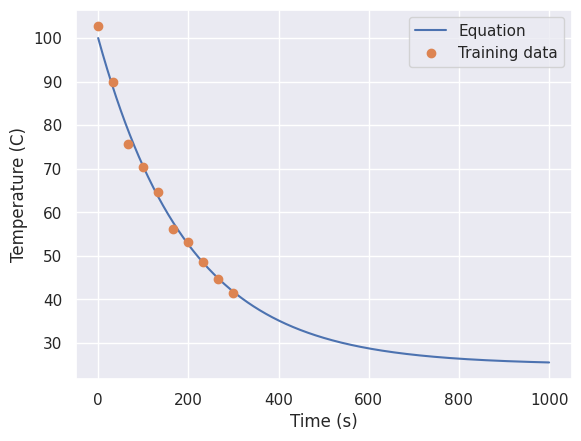

In [28]:
np.random.seed(10)

Tenv = 25
T0 = 100
R = 0.005
times = np.linspace(0, 1000, 1000)
eq = functools.partial(cooling_law, Tenv=Tenv, T0=T0, R=R)
temps = eq(times)

# Make training data
t = np.linspace(0, 300, 10)
T = eq(t) +  2 * np.random.randn(10)

plt.plot(times, temps)
plt.plot(t, T, 'o')
plt.legend(['Equation', 'Training data'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')

Vanilla Networks

Epoch 0/20000, loss: 4713.87
Epoch 2000/20000, loss: 2510.25
Epoch 4000/20000, loss: 2143.06
Epoch 6000/20000, loss: 727.61
Epoch 8000/20000, loss: 88.14
Epoch 10000/20000, loss: 1.57
Epoch 12000/20000, loss: 0.37
Epoch 14000/20000, loss: 0.34
Epoch 16000/20000, loss: 0.34
Epoch 18000/20000, loss: 0.33


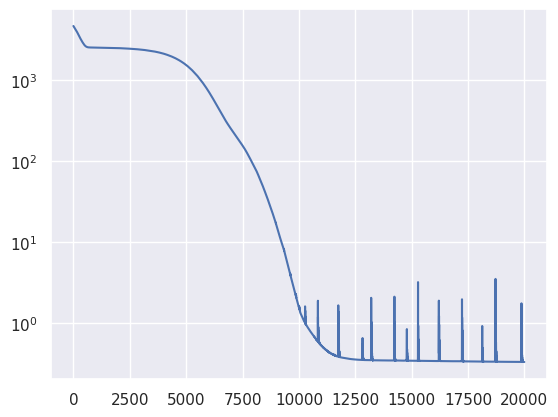

In [29]:
net = Net(1,1, loss2=None, epochs=20000, lr=1e-5).to(DEVICE)

losses = net.fit(t, T)

plt.plot(losses)
plt.yscale('log')

In [30]:
def l2_reg(model: torch.nn.Module):
    return torch.sum(sum([p.pow(2.) for p in model.parameters()]))

Epoch 0/20000, loss: 11220.99
Epoch 2000/20000, loss: 3918.13
Epoch 4000/20000, loss: 2461.16
Epoch 6000/20000, loss: 1626.99
Epoch 8000/20000, loss: 1215.28
Epoch 10000/20000, loss: 1026.62
Epoch 12000/20000, loss: 929.71
Epoch 14000/20000, loss: 856.02
Epoch 16000/20000, loss: 790.49
Epoch 18000/20000, loss: 729.66


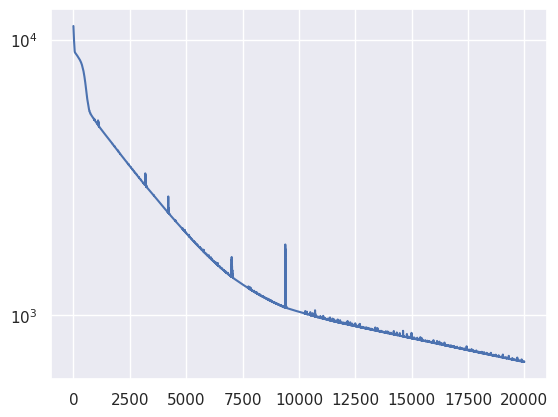

In [31]:
netreg = Net(1,1, loss2=l2_reg, epochs=20000, lr=1e-4, loss2_weight=1).to(DEVICE)

losses = netreg.fit(t, T)

plt.plot(losses)
plt.yscale('log')

Text(0.5, 0, 'Time (s)')

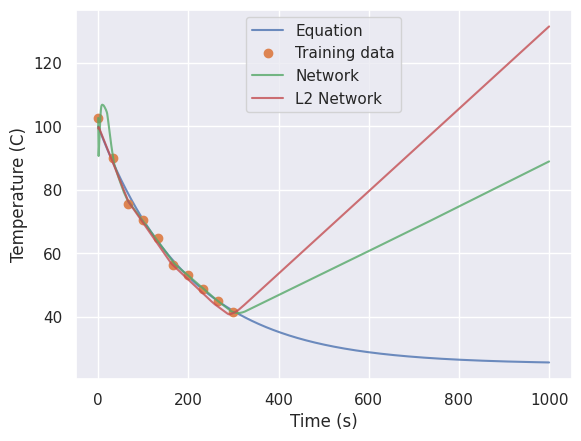

In [32]:
predsreg = netreg.predict(times)

preds = net.predict(times)
plt.plot(times, temps, alpha=0.8)
plt.plot(t, T, 'o')
plt.plot(times, preds, alpha=0.8)
plt.plot(times, predsreg, alpha=0.8)

plt.legend(labels=['Equation','Training data', 'Network', 'L2 Network'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')

PINNs

In [33]:
def physics_loss(model: torch.nn.Module):
    ts = torch.linspace(0, 1000, steps=1000,).view(-1,1).requires_grad_(True).to(DEVICE)
    temps = model(ts)
    dT = grad(temps, ts)[0]
    pde = R*(Tenv - temps) - dT
    
    return torch.mean(pde**2)

Epoch 0/30000, loss: 4776.84
Epoch 3000/30000, loss: 2435.38
Epoch 6000/30000, loss: 497.40
Epoch 9000/30000, loss: 1.96
Epoch 12000/30000, loss: 1.55
Epoch 15000/30000, loss: 1.37
Epoch 18000/30000, loss: 1.36
Epoch 21000/30000, loss: 1.34
Epoch 24000/30000, loss: 1.33
Epoch 27000/30000, loss: 1.33


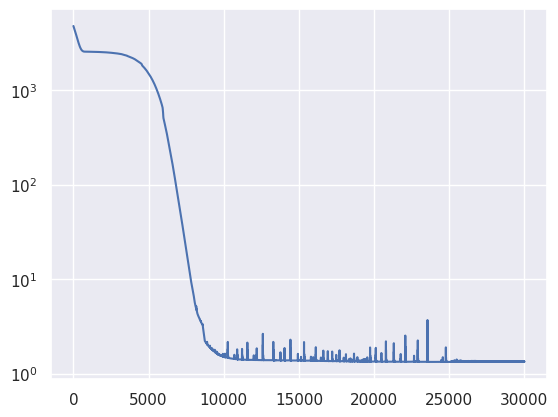

In [34]:
net = Net(1,1, loss2=physics_loss, epochs=30000, loss2_weight=1, lr=1e-5).to(DEVICE)

losses = net.fit(t, T)
plt.plot(losses)
plt.yscale('log')

Text(0.5, 0, 'Time (s)')

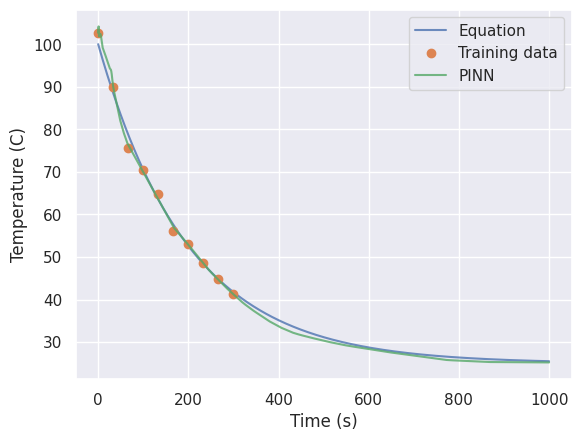

In [35]:
preds = net.predict(times)

plt.plot(times, temps, alpha=0.8)
plt.plot(t, T, 'o')
plt.plot(times, preds, alpha=0.8)
plt.legend(labels=['Equation','Training data', 'PINN'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')

Parameter discovery

In [36]:
def physics_loss_discovery(model: torch.nn.Module):
    ts = torch.linspace(0, 1000, steps=1000,).view(-1,1).requires_grad_(True).to(DEVICE)
    temps = model(ts)
    dT = grad(temps, ts)[0]
    pde = model.r * (Tenv - temps) - dT
    
    return torch.mean(pde**2)

Epoch 0/40000, loss: 4817.01
Epoch 4000/40000, loss: 2502.57
Epoch 8000/40000, loss: 2076.30
Epoch 12000/40000, loss: 560.56
Epoch 16000/40000, loss: 5.06
Epoch 20000/40000, loss: 2.27
Epoch 24000/40000, loss: 1.91
Epoch 28000/40000, loss: 1.53
Epoch 32000/40000, loss: 1.29
Epoch 36000/40000, loss: 1.18


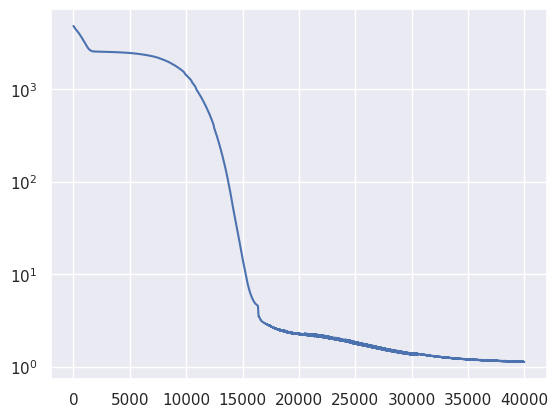

In [37]:
netdisc = NetDiscovery(1, 1, loss2=physics_loss_discovery, loss2_weight=1, epochs=40000, lr= 5e-6).to(DEVICE)

losses = netdisc.fit(t, T)
plt.plot(losses)
plt.yscale('log')

Parameter containing:
tensor([0.0052], requires_grad=True)


Text(0.5, 0, 'Time (s)')

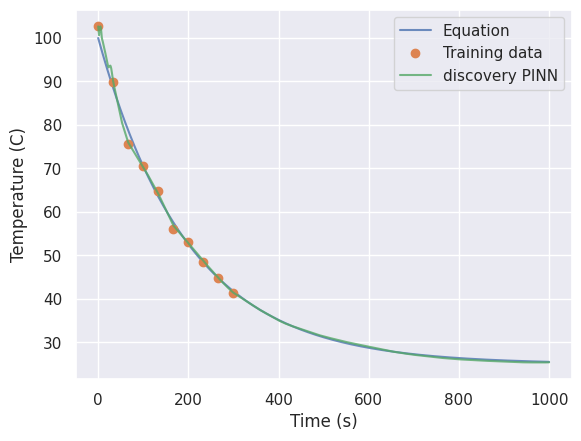

In [38]:
preds = netdisc.predict(times)
print(netdisc.r)

plt.plot(times, temps, alpha=0.8)
plt.plot(t, T, 'o')
plt.plot(times, preds, alpha=0.8)
plt.legend(labels=['Equation','Training data', 'discovery PINN'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')